# Tutorial
#### Interpreting Sum-Product Networks via Influence Functions

This tutorial shows by means of a full code example how to use the implementation of the
approximation of influence values for SPNs and how to plot these
influences. See the readme file for a quick topic intro.

We are going to apply IFs to SPNs in the context of a randomly generated 2D
classification dataset.

## Libraries
> **Caution: this step needs manual action.**

First, we import all necessary libraries.

In [0]:
import numpy as np
# import os
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from mpl_toolkits.axes_grid1 import make_axes_locatable

# from spn.io.Graphics import plot_spn  # plot SPN
from spn.structure.Base import Context  # for SPN learning
from spn.algorithms.LearningWrappers import learn_parametric, learn_classifier  # for SPN learning
from spn.structure.leaves.parametric.Parametric import Categorical  # leaf node type
from spn.structure.leaves.parametric.Parametric import Gaussian  # leaf node type
from spn.algorithms.Statistics import get_structure_stats  # SPN statistics output
from spn.algorithms.Marginalization import marginalize  # SPN marginalization
from src.InterpretableSpn import InterpretableSpn
from src.influence.dataset import DataSet  # for train and test set creation
from src.help_functions import *
from spn.algorithms.Inference import likelihood  # likelihood inference
from spn.algorithms.Inference import log_likelihood  # log-likelihood computation

### SPFlow library modifications
After installing the [SPFlow](https://github.com/SPFlow/SPFlow) library, we need to make two modifications of the SPFlow library (located in the library installation folder `Lib/site-packages`) in order to make our code executable.

1. Open the file `spn\structure\leaves\parametric\Tensorflow.py`, go to line 101, that is, to the definition of the function `categorical_to_tf_graph()`, and replace the entire function definition by the following code:
```
	def categorical_to_tf_graph(node, data_placeholder=None, log_space=True, variable_dict=None, dtype=np.float32):
	    print("Modified SPFlow library: wrapped categorical nodes with tf.stop_gradient()")
	    with tf.variable_scope("%s_%s" % (node.__class__.__name__, node.id)):
	        p = np.array(node.p, dtype=dtype)
	        softmaxInverse = np.log(p / np.max(p)).astype(dtype)
	        probs = tf.nn.softmax(tf.get_variable("p", initializer=tf.constant(softmaxInverse), trainable=False))  # Modded line
	        variable_dict[node] = probs
	        if log_space:
	            return tf.stop_gradient(tf.distributions.Categorical(probs=probs).log_prob(data_placeholder[:, node.scope[0]]))  # Modded line
	
        return tf.stop_gradient(tf.distributions.Categorical(probs=probs).prob(data_placeholder[:, node.scope[0]]))  # Modded line
```
This is necessary because, otherwise, the IF algorithm tries to compute the derivative of categorical nodes, causing an error.
2. Open the file `spn\structure\leaves\parametric\MLE.py` and go to line 40, that is, an `if` statement, and replace the whole `if` statement by the following code:
```
    if isinstance(node, Gaussian):
        node.mean = [np.mean(data).item()]
        node.stdev = [np.std(data).item()]

        if np.isclose(node.stdev, 0):
            node.stdev = [0.00000001]
```
This is necessary because the influence function algorithm requires these parameters to have dimension > 0.

## Parameters
Next, we collectively set all parameters which will be used later in this script.

### Dataset parameters
* `dataset_loader`: specifies type of dataset to be generated. Select from the following:
  * `generate_linear` for a linearly separable two-class dataset
  * `generate_non_linear` for a non-linearly separable two-class dataset
  * `generate_three` for a three-class dataset
* `dataset_name`: custom string used to identify the folder where the plots are saved later
* `no_train_ex`: number of examples in the training set
* `no_test_ex`: number of examples in the test set
* `noisy_dataset`: when `True`, the generated data set is noisy, i.e., some examples near
  the decision boundary have a false label
* `seed`: number for exact reproduction of past results

In [0]:
dataset_loader = generate_three
dataset_name = "three"
no_train_ex = 200
no_test_ex = 1024
noisy_dataset = True
seed = 23081996

### Influence parameters

* `ref_id`: index of the **reference example** picked from the test set. This example 
  (consisting of features and a label) will later be used to approximate the model's loss
  on that reference example.
* `ref_features`: if a value is given, the features of the reference example are
  set to the given value, use `None` for original features
* `ref_label`: if a value is given, the label of the reference example is set to
  the given value, use `None` for original label
* `ignore_weights`: when `True`, **weight parameters** from sum nodes are ignored for
  influence computation
* `ignore_means`: when `True`, **mean parameters** from Gaussian nodes are ignored for
  influence computation
* `ignore_variances`: when `True`, **stdev parameters** from Gaussian nodes are
  ignored for influence computation
* `loss`: value whose negation is then used as the loss. Select
  from the following two (where $X$ is the input features and $Y$ the label of the
  reference example):
   * `"joint"` is the joint log-likelihood $P(X, Y)$
   * `"conditional"`: is the conditional log-likelihood $P(Y|X)$
* `n`: number of train examples whose influence on the model shall be approximated (not more than `num_train_samples`)

In [0]:
ref_id = 450
ref_features = None
ref_label = None
ignore_weights = False
ignore_means = False
ignore_variances = False
loss = "joint"
n = no_train_ex

### Paths and names

* `spn_name`: custom string which specifies a name for the SPN, used as filenames for saved, trained SPN parameters
* `output_path`: the root path of all outputs (trained SPN parameters, plots, etc.)
* `plot_name`: name of the PDF file containing all plots
* `plot_path`: path of the aforementioned PDF file (relative to `output_path`)
* `force_overwrite`: overwrite existing plot file if it exists
* `save_spn`: if `True`, SPN is saved with Pickle after training under its `spn_name`

In [0]:
spn_name = "2d_spn"
output_path = "output"
plot_name = "%d_%s" % (ref_id, loss)
plot_path = output_path + "/plots/%s/%s" % (dataset_name, plot_name)
force_overwrite = True
save_spn = True

### SPN learning parameters

* `min_instances_slice`: smaller value leads to deeper SPN (default 200)
* `threshold`: smaller value leads to more product nodes (default 0.3)

In [0]:
# SPN learning parameters
min_instances_slice = 200  # Smaller value leads to deeper SPN (default 200)
threshold = 0.5  # Smaller value leads to more product nodes (default 0.3)

### Hessian-vector-product approximation parameters
The approximation algorithm LiSSA is used to efficiently estimate the product of a Hessian
and a vector. 
* `scale`: default 10
* `damping`: select from interval $[0, 1)$ (default 0.01)
* `recursion_depth`: default 100

In [0]:
scale = 10
damping = 0.01  # Select in interval [0, 1)
recursion_depth = 100

### Miscellaneous parameters

* `plot_res`: plot resolution of some certain plots (the decision boundary and likelihood plot)
* `os.environ["CUDA_VISIBLE_DEVICES"]`: index of GPU to be used (-1 for no GPU usage)
* `num_threads`: number threads established for SPN learning

In [0]:
plot_res = 100  # Resolution of the decision boundary and likelihood plots
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # GPUs to be used (-1 for no GPUs)
num_threads = 32  # Number threads used for SPN learning

## Data initialization & model setup
First, we initialize the PDF output file for the plots.

In [0]:
# Create folder for plots (if not existing yet)
create_dir(plot_path, force_overwrite=force_overwrite)
# Start a new PDF file which will eventually contain all plots
pdf = matplotlib.backends.backend_pdf.PdfPages(plot_path + "/" + plot_name + ".pdf")

Now, we set a state for the random number generator, using the seed. Then, we generate a new dataset using
`dataset_loader` and reformat the generated dataset structure according to our needs.

In [0]:
# Get train and test set
np.random.seed(seed=seed)
(train_samples, train_labels), (test_samples, test_labels) = dataset_loader(no_train_ex,
                                                                            no_test_ex,
                                                                            noise=noisy_dataset)
# Expand train and test sets by one dimension needed later
train_labels = np.expand_dims(train_labels, 1)
test_labels = np.expand_dims(test_labels, 1)

Above we selected the number `ref_id` for the reference example (which is used as reference for the loss). If we also set a custom label and/or
custom features, we apply them here:

In [0]:
# Apply custom values (if given) to the reference example
if ref_label is not None:
    # Redefine the label of the reference example
    test_labels[ref_id] = ref_label
if ref_features is not None:
    # Redefine the feature values of the reference example
    test_samples[ref_id] = ref_features

Next, we prepare the train and test sets, necessary for learning and for
influence investigation.

In [0]:
# Combine labels and features for the learning procedure
train_data = np.column_stack((train_samples, train_labels))
test_data = np.column_stack((test_samples, test_labels))

# Create TF DataSet structures for influence investigation
train_set = DataSet(train_samples, train_labels)
test_set = DataSet(test_samples, test_labels)
validation_set = None
data_sets = base.Datasets(train=train_set, test=test_set, validation=validation_set)

Let's plot train and test set to see how they look like.

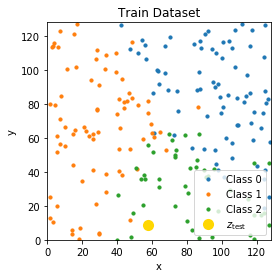

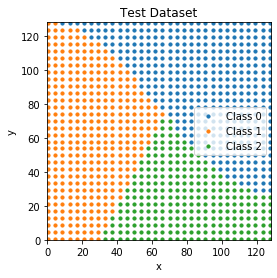

In [0]:
# Plot train set with reference example
plot_samples(train_samples, train_labels, plot_pdf=pdf,
             plot_title='Train Dataset', ref_ex=test_samples[ref_id])

# Plot test set
plot_samples(test_samples, test_labels, plot_pdf=pdf,
             plot_title='Test Dataset', size=10)

Next, we learn the SPN.

In [0]:
# Prepare some (insignificant) learning variables
parametric_types = [Gaussian, Gaussian, Categorical]
context = Context(parametric_types=parametric_types).add_domains(train_data)
label_idx = 2
batch_size = 1

# Model training
print('\033[1mStart SPN training...\033[0m')
start_time = time.time()

spn = learn_classifier(data=train_data,
                       ds_context=context,
                       spn_learn_wrapper=learn_parametric,
                       label_idx=label_idx,
                       min_instances_slice=min_instances_slice,
                       threshold=threshold,
                       cpus=num_threads)

duration = time.time() - start_time
print('\033[1mFinished training after %.3f sec.\033[0m' % duration)

Start SPN training...
Finished training after 2.725 sec.


Then, we evaluate the model's performance, save a text file with the used learning
parameters for documentation and plot the resulted test predictions.

---Structure Statistics---
# nodes             13
    # sum nodes     1
    # prod nodes    3
    # leaf nodes    9
# params            18
# edges             12
# layers            3

Train set performance:
Train sample count: 200
Train set accuracy: 85.50 %

Test set performance:
Test sample count: 1024
Test set accuracy: 87.60 %



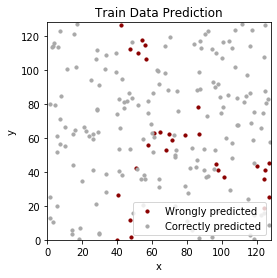

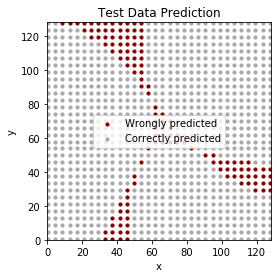

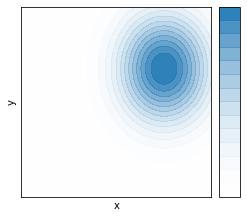

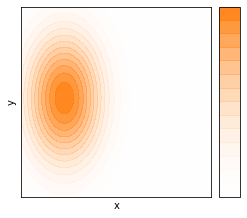

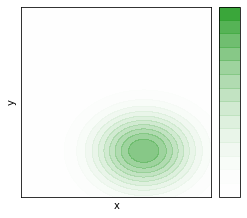

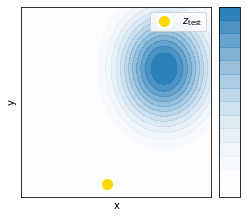

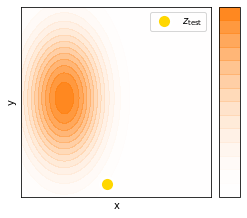

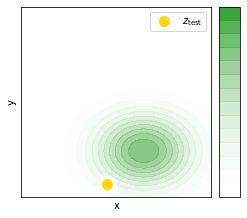

In [0]:
# Model performance evaluation
spn_stats = get_structure_stats(spn)
print(spn_stats, end="")
stats_file = open(plot_path + "/spn_stats.txt", "w+")
stats_file.write(spn_stats)
# plot_spn(spn, plot_path + "/spn_struct.pdf")
(predicted_train_labels, correct_train_preds), (predicted_test_labels, correct_test_preds) = \
    evaluate_spn_performance(spn, train_samples, train_labels, test_samples,
                             test_labels, label_idx, stats_file)

# Save metadata into stats file
metadata = "\nSeed: %d\n" % seed + \
           "Reference ID: %d\n" % ref_id + \
           "Noisy dataset: %r\n" % noisy_dataset + \
           "Minimum instances per slice: %d\n" % min_instances_slice + \
           "Alpha (threshold): %f\n" % threshold + \
           "Type of loss: %s\n" % loss + \
           "Weights ignored: %r\n" % ignore_weights + \
           "Means ignored: %r\n" % ignore_means + \
           "Variances ignored: %r\n" % ignore_variances + \
           "Lissa parameters:\n" + \
           "   - Scale: %f\n" % scale + \
           "   - Damping: %.1e\n" % damping + \
           "   - Recursion depth: %d\n" % recursion_depth
stats_file.write(metadata)

# Plot train predictions
plot_samples(train_samples, correct_train_preds, plot_pdf=pdf,
             plot_title='Train Data Prediction',
             classes=[False, True],
             size=10,
             colors=["darkred", "darkgray"],
             plot_labels=["Wrongly predicted", "Correctly predicted"])

# Plot test predictions
plot_samples(test_samples, correct_test_preds, plot_pdf=pdf,
             plot_title='Test Data Prediction',
             classes=[False, True],
             size=10,
             colors=["darkred", "darkgray"],
             plot_labels=["Wrongly predicted", "Correctly predicted"])

# Plot likelihoods
plot_likelihoods(spn=spn,
                 classes=np.sort(np.unique(test_labels)),
                 res=plot_res,
                 plot_pdf=pdf)

# Plot likelihoods with test sample
plot_likelihoods(spn=spn,
                 classes=np.sort(np.unique(test_labels)),
                 res=plot_res,
                 plot_pdf=pdf,
                 test_sample=test_samples[ref_id])

Now, we create a marginalized version of the SPN by marginalizing out the label nodes. The marginalized SPN's root node represents the sum of all class probabilities of a given
feature input (example without label).

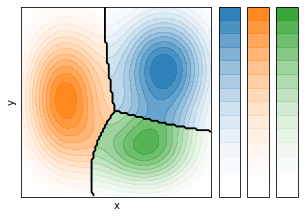

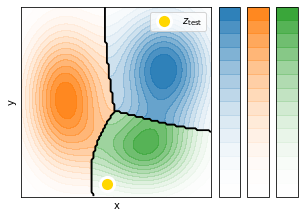

In [0]:
# Marginalize SPN
spn_marg = marginalize(spn, [0, 1])

# Plot decision boundaries
plot_decision_boundaries(spn=spn,
                         marg_spn=spn_marg,
                         classes=np.sort(np.unique(test_labels)),
                         res=plot_res,
                         plot_pdf=pdf)

# Plot decision boundaries with reference sample
plot_decision_boundaries(spn=spn,
                         marg_spn=spn_marg,
                         classes=np.sort(np.unique(test_labels)),
                         res=plot_res,
                         plot_pdf=pdf,
                         test_sample=test_samples[ref_id])

Make some calculations with the SPN to see whether it works correctly.

In [0]:
# SPN sanity check
ll = log_likelihood(spn, np.array([test_data[ref_id]]))
ll_marg = log_likelihood(spn_marg, np.array([test_data[ref_id]]))
print("Let t be the reference sample with ID %d, which is:" % ref_id)
print(test_data[ref_id])
print("Log-likelihood of t:", ll)
print("Likelihood of t:", np.exp(ll))
print("Marginal log-likelihood of t:", ll_marg)
print("Marginal likelihood of t:", np.exp(ll_marg))

Let t be the Golden Sample with ID 450, which is:
[57.85484   8.693548  2.      ]
Log-likelihood of t: [[-10.66810626]]
Likelihood of t: [[2.32755697e-05]]
Marginal log-likelihood of t: [[-10.39608535]]
Marginal likelihood of t: [[3.05518489e-05]]


We convert both SPN models (normal and marginalized) into TF computation graphs.
This step is necessary because the influence inspection script works only on TF
graphs. Then, we export and import these graphs (again), because we need to append
placeholders at the beginning of the computation graphs.

In [0]:
# Convert the SPN into a TF computation graph
spn_tensor, _, _ = convert_spn_to_tf_graph(
    spn,
    test_data,
    batch_size=batch_size,
    dtype=np.float32
)

# Export the model
root = tf.identity(spn_tensor, name="Root")
export_dir = export_model(root_dir=output_path, export_dir="/spns/tf_" + spn_name, force_overwrite=True)
print("Successfully exported SPN tensor to \"%s\"." % export_dir)

tf.reset_default_graph()

# Convert the marginalized SPN into a TF computation graph
spn_marg_tensor, _, _ = convert_spn_to_tf_graph(
    spn_marg,
    test_data,
    batch_size=batch_size,
    dtype=np.float32
)

# Export the marginalized model
root_marg = tf.identity(spn_marg_tensor, name="Root")
export_dir = export_model(root_dir=output_path, export_dir="/spns/tf_" + spn_name + "_marg", force_overwrite=True)
print("Successfully exported marginal SPN tensor to \"%s\"." % export_dir)

tf.reset_default_graph()

# Define placeholders
sample_placeholder = tf.placeholder(dtype=np.float32,
                                    shape=(batch_size, test_samples.shape[1]),
                                    name="Sample_Placeholder")
label_placeholder = tf.placeholder(dtype=np.float32,
                                   shape=(batch_size, test_labels.shape[1]),
                                   name="Label_Placeholder")
input_placeholder = tf.concat([sample_placeholder, label_placeholder], 1)
input_marg = tf.concat([sample_placeholder, [[np.nan]]], 1)

# Import the models with the new placeholders
with tf.name_scope("SPN"):
    input_map = {"Placeholder:0": input_placeholder}
    restored_spn_graph = import_model(output_path + "/spns/tf_" + spn_name, input_map)
    new_root = restored_spn_graph.get_tensor_by_name("SPN/Root:0")

with tf.name_scope("SPN_Marg"):
    input_map_marg = {"Placeholder:0": input_marg}
    restored_marg_spn_graph = import_model(output_path + "/spns/tf_" + spn_name + "_marg", input_map_marg)
    new_root_marg = restored_marg_spn_graph.get_tensor_by_name("SPN_Marg/Root:0")

# Try if models run consistently
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    print('\033[1mStart bottom-up evaluation...\033[0m')
    start_time = time.time()

    results = sess.run([new_root, new_root_marg], feed_dict={"Sample_Placeholder:0": [test_samples[ref_id]],
                                                             "Label_Placeholder:0": [test_labels[ref_id]]})
    print("Log-likelihood:", results[0])
    print("Likelihood:", np.exp(results[0]))
    print("Marginal log-likelihood:", results[1])
    print("Marginal likelihood:", np.exp(results[1]))

    duration = time.time() - start_time
    print('\033[1mFinished bottom-up evaluation after %.3f sec.\033[0m' % duration)

Now, it's getting more interesting. We initialize an `InterpretableSpn` object for
the normal SPN. This step might take some time because
it involves the expansion of the TF graph with the derivative of the SPN. This is
computationally expensive with increasing model size. After that, we again make
some sanity checks.

In [0]:
# Initialize interpretable SPN
model_name = "SPN"

print('\033[1mStart InterpretableSpn class initialization...\033[0m')
start_time = time.time()

interpretable_spn = InterpretableSpn(root_node=new_root,
                                     root_node_marg=new_root_marg,
                                     sample_placeholder=sample_placeholder,
                                     label_placeholder=label_placeholder,
                                     data_sets=data_sets,
                                     model_name=model_name,
                                     train_dir=output_path + '/training',
                                     ignore_weights=ignore_weights,
                                     ignore_means=ignore_means,
                                     ignore_variances=ignore_variances,
                                     type_of_loss=loss)

duration = time.time() - start_time
print('\033[1mFinished initialization after %.3f sec.\033[0m' % duration)

# Loss sanity check
print('\033[1mStart bottom-up evaluation...\033[0m')
start_time = time.time()

# Create a graph log file to visualize the TF graph with TensorBoard
result = plot_tf_graph(graph_elem=interpretable_spn.total_loss,
                       feed_dict={"Sample_Placeholder:0": [test_samples[ref_id]],
                                  "Label_Placeholder:0": [test_labels[ref_id]]},
                       log_dir=output_path + "/logs",
                       sess=interpretable_spn.sess)

print("Loss of reference example:", result)

duration = time.time() - start_time
print('\033[1mFinished bottom-up evaluation after %.3f sec.\033[0m' % duration)

Let's plot the gradient of the loss on all test examples with respect to their features.
This results in a vector field where each vector indicates the direction of the
steepest ascent of the loss. Moving a test point into the direction of its vector
would result in an increased loss on that example.

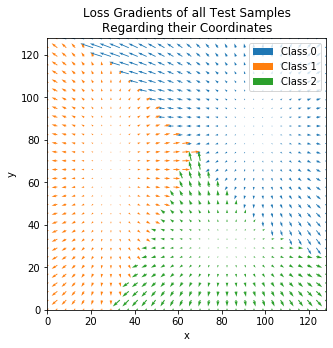

In [0]:
# Loss gradients
grads = interpretable_spn.get_grad_loss_wrt_input(range(0, len(test_samples)))

plot_gradients(gradients=grads,
               samples=test_samples,
               plot_title='Loss Gradients of all Test Samples\nRegarding their Coordinates',
               plot_pdf=pdf,
               labels=test_labels)

## Influence inspection
Finally, we're all set with our preparations and can target our core work: estimate influences. Each influence computation
results in a plot, saved in the previously initialized PDF file.

### Influence values
Here, we approximate the influence of each training example having on the model's
prediciton performance on the selected reference example. We make a less
exact approximation (without the Hessian matrix) and a more exact
approximation (with Hessian). Each will be plotted with two different plots
using different color schemes.

> This is the **second** influence function of [Koh et al., 2017](http://proceedings.mlr.press/v70/koh17a/koh17a.pdf).

#### Without Hessian

Input feed: [[57.85484   8.693548]]
Labels feed: [2.]
Norm of test gradient: 0.9524368
Inverse HVP took 0.0 sec
Multiplying by 200 train examples took 0.8104355335235596 sec


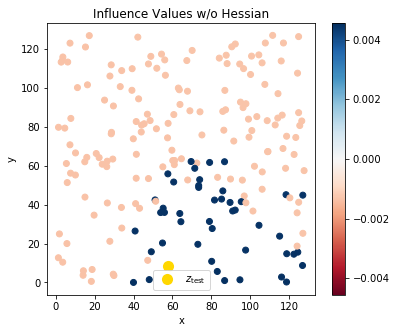

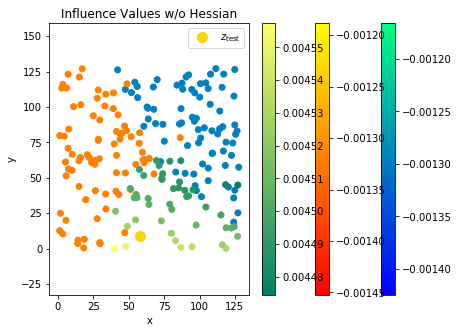

In [0]:
influences_no_hess = interpretable_spn.get_influence_on_test_loss(test_indices=[ref_id],
                                                                  train_idx=range(0, n),
                                                                  ignore_hessian=True)

plot_influences(influences=influences_no_hess,
                samples=train_samples,
                plot_title='Influence Values w/o Hessian',
                plot_pdf=pdf,
                test_sample=test_samples[ref_id])

plot_influences_with_multiple_colors(influences=influences_no_hess,
                                     samples=train_samples,
                                     labels=train_labels,
                                     plot_title='Influence Values w/o Hessian',
                                     plot_pdf=pdf,
                                     test_sample=test_samples[ref_id])

#### With Hessian

Input feed: [[57.85484   8.693548]]
Labels feed: [2.]
Norm of test gradient: 0.9524368
Recursion at depth 0: norm is 1.87060738
Recursion at depth 10: norm is 9.41958523
Recursion at depth 20: norm is 14.65891075
Recursion at depth 30: norm is 18.30097389
Recursion at depth 40: norm is 20.83836555
Recursion at depth 50: norm is 22.61125374
Recursion at depth 60: norm is 23.85547447
Recursion at depth 70: norm is 24.73295784
Recursion at depth 80: norm is 25.35624504
Recursion at depth 90: norm is 25.80280495
Recursion at depth 99: norm is 26.09906006
Saved inverse HVPInverse HVP took 2.018921136856079 sec
Multiplying by 200 train examples took 0.4985055923461914 sec


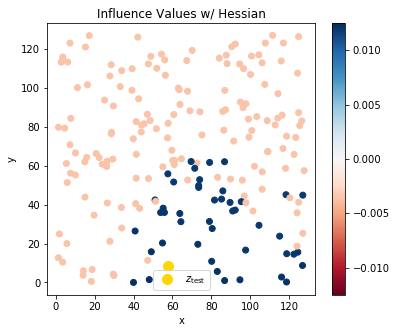

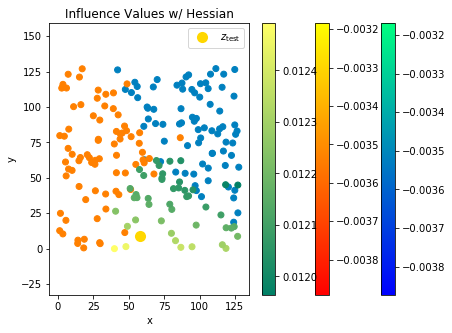

In [0]:
influences_hess = interpretable_spn.get_influence_on_test_loss(test_indices=[ref_id],
                                                               train_idx=range(0, n),
                                                               ignore_hessian=False,
                                                               force_refresh=True,
                                                               approx_type='lissa',
                                                               approx_params={"batch_size": batch_size,
                                                                              "scale": scale,
                                                                              "damping": damping,
                                                                              "num_samples": 1,
                                                                              "recursion_depth": recursion_depth},
                                                               output_file=stats_file)

plot_influences(influences=influences_hess,
                samples=train_samples,
                plot_title='Influence Values w/ Hessian',
                plot_pdf=pdf,
                test_sample=test_samples[ref_id])

plot_influences_with_multiple_colors(influences=influences_hess,
                                     samples=train_samples,
                                     labels=train_labels,
                                     plot_title='Influence Values w/ Hessian',
                                     plot_pdf=pdf,
                                     test_sample=test_samples[ref_id])

### Influence gradients
In this section, we approximate the influence gradient of the prediction
performance on the reference example for each train sample. Similar to the plain
gradient plot before, we receive vector fields.

> This is the **third** influence function of [Koh et al., 2017](http://proceedings.mlr.press/v70/koh17a/koh17a.pdf).

#### Without Hessian

Input feed: [[57.85484   8.693548]]
Labels feed: [2.]
Norm of test gradient: 0.9524368
Inverse HVP took 0.0 sec


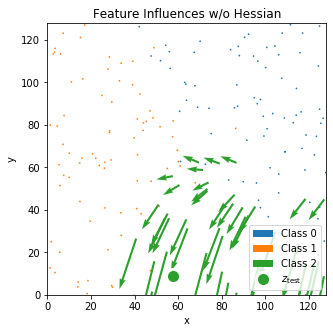

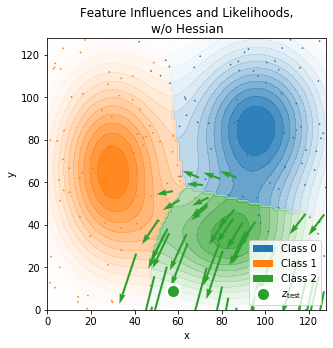

In [0]:
# Approximate influence gradients
influence_grads = interpretable_spn.get_grad_of_influence_wrt_input(test_indices=[ref_id],
                                                                    train_indices=range(0, n),
                                                                    ignore_hessian=True)

# Plot the vector field
plot_gradients(gradients=influence_grads,
               samples=train_samples,
               test_sample=test_samples[ref_id],
               test_label=test_labels[ref_id],
               labels=train_labels,
               plot_title='Feature Influences w/o Hessian',
               plot_pdf=pdf)

# Plot the vector field combined with class likelihoods
plot_gradients_with_likelihoods(spn=spn,
                                marg_spn=spn_marg,
                                gradients=influence_grads,
                                classes=np.sort(np.unique(test_labels)),
                                train_samples=train_samples,
                                test_sample=test_samples[ref_id],
                                test_sample_label=test_labels[ref_id],
                                true_train_labels=train_labels,
                                res=plot_res,
                                plot_title='Feature Influences and Likelihoods,\n'
                                           'w/o Hessian',
                                plot_pdf=pdf)

#### With Hessian

Input feed: [[57.85484   8.693548]]
Labels feed: [2.]
Norm of test gradient: 0.9524368
Loaded inverse HVPInverse HVP took 0.003396749496459961 sec


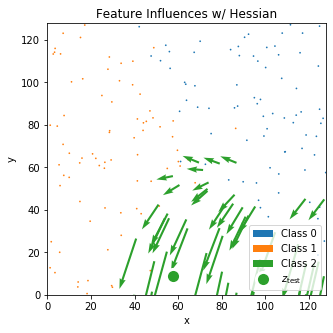

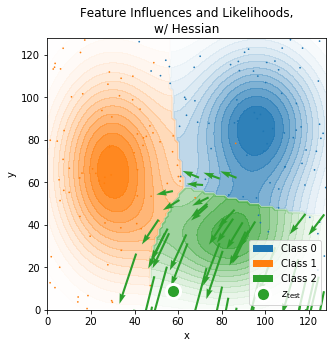

In [0]:
# Approximate influence gradients
influence_grads = interpretable_spn.get_grad_of_influence_wrt_input(test_indices=[ref_id],
                                                                    train_indices=range(0, n),
                                                                    ignore_hessian=False,
                                                                    force_refresh=False,
                                                                    approx_type='lissa')

# Plot the vector field
plot_gradients(gradients=influence_grads,
               samples=train_samples,
               test_sample=test_samples[ref_id],
               test_label=test_labels[ref_id],
               labels=train_labels,
               plot_title='Feature Influences w/ Hessian',
               plot_pdf=pdf)

# Plot the vector field combined with class likelihoods
plot_gradients_with_likelihoods(spn=spn,
                                marg_spn=spn_marg,
                                gradients=influence_grads,
                                classes=np.sort(np.unique(test_labels)),
                                train_samples=train_samples,
                                test_sample=test_samples[ref_id],
                                test_sample_label=test_labels[ref_id],
                                true_train_labels=train_labels,
                                res=plot_res,
                                plot_title='Feature Influences and Likelihoods,\n'
                                           'w/ Hessian',
                                plot_pdf=pdf)

### Influence comparison (w/ vs. w/o Hessian)
Here, we compare the influence values of the less exact approximation (which
ignored the Hessian) and the more exact approximation (which used the Hessian).
For each example, we plot a dot in the 2D plane, where $x$ is the influence
value w/o Hessian and $y$ is the influence value w/ Hessian. The more the dots
deviate from the (dashed) diagonal line, the more differ the two influence
approximations.

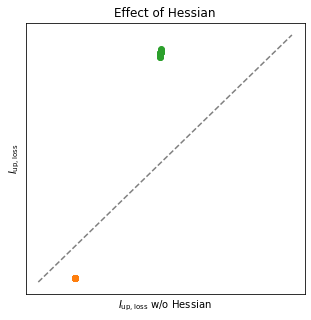

In [0]:
influences = [influences_no_hess, influences_hess]
plot_influence_components(influences, labels=train_labels, plot_pdf=pdf)

## Terminate computation
Finally, close all active files to save them neatly.

In [0]:
stats_file.close()
pdf.close()